In [1]:
!ls ../input/*

../input/competitive-data-science-predict-future-sales:
item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv

../input/pfs-dataprep:
__notebook__.ipynb  __results__.html   custom.css  mean_benchmark.csv
__output__.json     __results___files  data.h5	   prev_month_benchmark.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import gc

from lightgbm import LGBMRegressor
from lightgbm import plotting
from sklearn.ensemble import BaggingRegressor

from hyperopt import hp, tpe, Trials, space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

In [3]:
SEED = 42
DATA_PATH = '../input/pfs-dataprep/data.h5'
# Number of rows for tuning and training
TUNE_ROWS = 600000 # (~2 months)
TRAIN_ROWS = 3000000 # (~10 months)
# Months to reserve for ensembling methods
META_MONTHS = 4

# Number of rounds in tuning procedure
MAX_EVALS = 30
# Number of estimators in bagging procedure 
BAGS = 5
EXCL_COLS = ['item_cnt_month']
# *item_id* has high cardinality, for LGBM it works best to treat this feature as numeric
# https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm
CAT_COLS = ['month', 'shop_id', 'item_category_id', 'city_id', 'type_id', 'subtype_id']
# fix learning rate and number of estimators for tuning tree-based parameters
FIXED_PARAMS = {
    'num_iterations': 1000,
    'learning_rate': 0.1,
    'random_state': SEED,
    'n_jobs': -1
}
STOP_ROUNDS = 30
SPACE = {
    'num_leaves': hp.choice('num_leaves', np.arange(10, 200, dtype=int)),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(10, 1000, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(6, 10, dtype=int)),
    'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
    'bagging_freq': hp.choice('bagging_freq', np.arange(1, 10, dtype=int)),
    'max_bin': hp.choice('max_bin', np.arange(32, 255, dtype=int)),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0)
}

In [4]:
%%time
traintest = pd.read_hdf(DATA_PATH, key='traintest')

print(traintest.shape)

(7393103, 59)
CPU times: user 12.7 s, sys: 8.4 s, total: 21.1 s
Wall time: 22.1 s


In [5]:
traintest[CAT_COLS] = traintest[CAT_COLS].astype('category', copy=False)

In [6]:
# Data for tuning is smaller to speed up the tuning process
tune_train_idx = traintest[traintest.date_block_num<33].sample(n=TUNE_ROWS, random_state=SEED).index
tune_valid_idx = traintest[traintest.date_block_num==33].index

# Train the model on a (big enough) random subset of data
train_idx = traintest[traintest.date_block_num<34-META_MONTHS].sample(n=TRAIN_ROWS, random_state=SEED).index
# We treat data for ensembling as test data
# We don't do time-sensitive KFold strategy here because our training set was chosen randomly which is sufficient
test_idx = traintest[traintest.date_block_num>=34-META_MONTHS].index

print(len(tune_train_idx), len(tune_valid_idx), len(train_idx), len(test_idx))

600000 238172 3000000 1114452


In [7]:
X_test = traintest.loc[test_idx].drop(EXCL_COLS, axis=1)

print(X_test.shape, sorted(X_test.date_block_num.unique()))

(1114452, 58) [30, 31, 32, 33, 34]


### Baseline

In [8]:
def rmse(y_true, y_pred):
    # Clipping required by the competition
    y_true = pd.Series(y_true).fillna(0).clip(0, 20).values
    y_pred = pd.Series(y_pred).fillna(0).clip(0, 20).values
    return sqrt(mean_squared_error(y_true, y_pred))

def rmse_metric(y_true, y_pred):
    score = rmse(y_true, y_pred)
    # eval_name, val, is_higher_better
    return 'rmse', score, False

In [9]:
def setup_and_fit_model(new_params={}, tuning=False, verbose=False):
    # Handy function to quickly setup a LightGBM instance
    lgbm = LGBMRegressor(**FIXED_PARAMS)
    lgbm.set_params(**new_params)
    
    if tuning:
        # Use a smaller training set to speed up tuning
        X_train = traintest.loc[tune_train_idx].drop(EXCL_COLS, axis=1)
        y_train = traintest.loc[tune_train_idx].item_cnt_month
        X_valid = traintest.loc[tune_valid_idx].drop(EXCL_COLS, axis=1)
        y_valid = traintest.loc[tune_valid_idx].item_cnt_month
    else:   
        # Use the whole training set with validation
        X_train = traintest.loc[train_idx].drop(EXCL_COLS, axis=1)
        y_train = traintest.loc[train_idx].item_cnt_month
        X_valid = traintest.loc[tune_valid_idx].drop(EXCL_COLS, axis=1)
        y_valid = traintest.loc[tune_valid_idx].item_cnt_month
    eval_params = {
        'eval_metric': rmse_metric,
        'eval_set': [(X_train, y_train), (X_valid, y_valid)],
        'early_stopping_rounds': STOP_ROUNDS
    }
    lgbm.fit(X_train, y_train, verbose=verbose, **eval_params)
    train_score = lgbm.best_score_['training']['rmse']
    valid_score = lgbm.best_score_['valid_1']['rmse']
    print("train_score {:.4f}, valid_score {:.4f}".format(train_score, valid_score))
        
    # force the Garbage Collector to release unreferenced memory
    gc.collect()
    return lgbm

In [10]:
%%time
lgbm = setup_and_fit_model()

train_score 0.8448, valid_score 0.9088
CPU times: user 5min 31s, sys: 13.7 s, total: 5min 44s
Wall time: 1min 52s


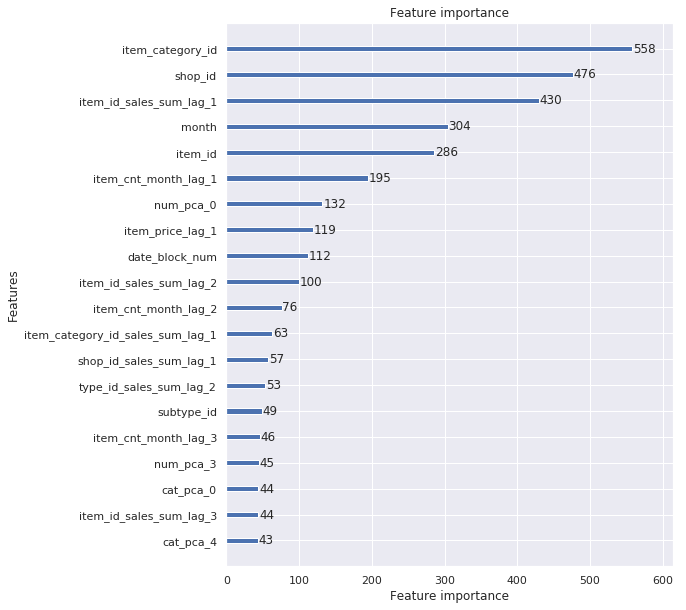

In [11]:
fig, ax = plt.subplots(figsize=(8, 10))

plotting.plot_importance(booster=lgbm, ax=ax, max_num_features=20);

In [12]:
baseline_preds = lgbm.predict(X_test)

print(baseline_preds.shape)

(1114452,)


### Hyperparamter tuning

In [13]:
# Useful resources:
# https://www.coursera.org/learn/competitive-data-science/lecture/wzi5a/hyperparameter-tuning-ii
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://github.com/arnaudvl/ml-parameter-optimization/blob/master/mlopt/lgb_tune.py

def objective_with_params(new_params={}):
    # Partial function to provide the objective with previously tuned parameters
    def objective(params):
        # Fit the LGBM regressor and return the score 
        lgbm = setup_and_fit_model(new_params={**new_params, **params}, tuning=True)
        score = lgbm.best_score_['valid_1']['rmse']
        return score
    return objective
    
def find_best_from_space(fn):
    # Tune parameters from the provided parameter space using *hyperopt*
    trials = Trials()
    best = fmin(fn=fn,
                space=SPACE,
                trials=trials,
                algo=tpe.suggest,
                max_evals=MAX_EVALS, 
                rstate=np.random.RandomState(SEED))
    # Retrieve best parameters from the space
    space_best = space_eval(SPACE, best)
    print(space_best)
    return space_best, trials

In [14]:
# tune parameters for the leaf-wise (best-first) tree
fn = objective_with_params()
tuned_params, trials = find_best_from_space(fn)

train_score 0.8690, valid_score 0.9132
train_score 0.8247, valid_score 0.9026
train_score 0.8574, valid_score 0.9098
train_score 0.8284, valid_score 0.9077
train_score 0.8454, valid_score 0.9086
train_score 0.8594, valid_score 0.9093
train_score 0.8434, valid_score 0.9127
train_score 0.8022, valid_score 0.9156
train_score 0.8421, valid_score 0.9045
train_score 0.8102, valid_score 0.9093
train_score 0.8381, valid_score 0.9042
train_score 0.8784, valid_score 0.9138
train_score 0.8577, valid_score 0.9098
train_score 0.8557, valid_score 0.9109
train_score 0.8530, valid_score 0.9117
train_score 0.8467, valid_score 0.9067
train_score 0.8506, valid_score 0.9127
train_score 0.7507, valid_score 0.9031
train_score 0.8402, valid_score 0.9085
train_score 0.8378, valid_score 0.9043
train_score 0.8196, valid_score 0.9083
train_score 0.8328, valid_score 0.9148
train_score 0.8138, valid_score 0.9091
train_score 0.8285, valid_score 0.9065
train_score 0.7953, valid_score 0.9132
train_score 0.8442, valid

In [15]:
def plot_trials(trials):
    # Draw the values from each parameter against the score
    param_list = SPACE.keys()
    nrows, ncols = len(param_list)//2+1, 2
    f = plt.figure(figsize=(6*ncols, 4*nrows))

    for i, param in enumerate(param_list):
        xs = np.array([t['misc']['vals'][param] for t in trials.trials]).ravel()
        ys = [t['result']['loss'] for t in trials.trials]
        plt.subplot(nrows, ncols, i+1)
        # Color represents time (from brighter to darker)
        plt.scatter(xs, ys, c=range(len(xs)), cmap=plt.cm.YlGnBu)
        plt.xlabel(param)
        plt.ylabel('RMSE')
        
    plt.tight_layout()
    plt.show()

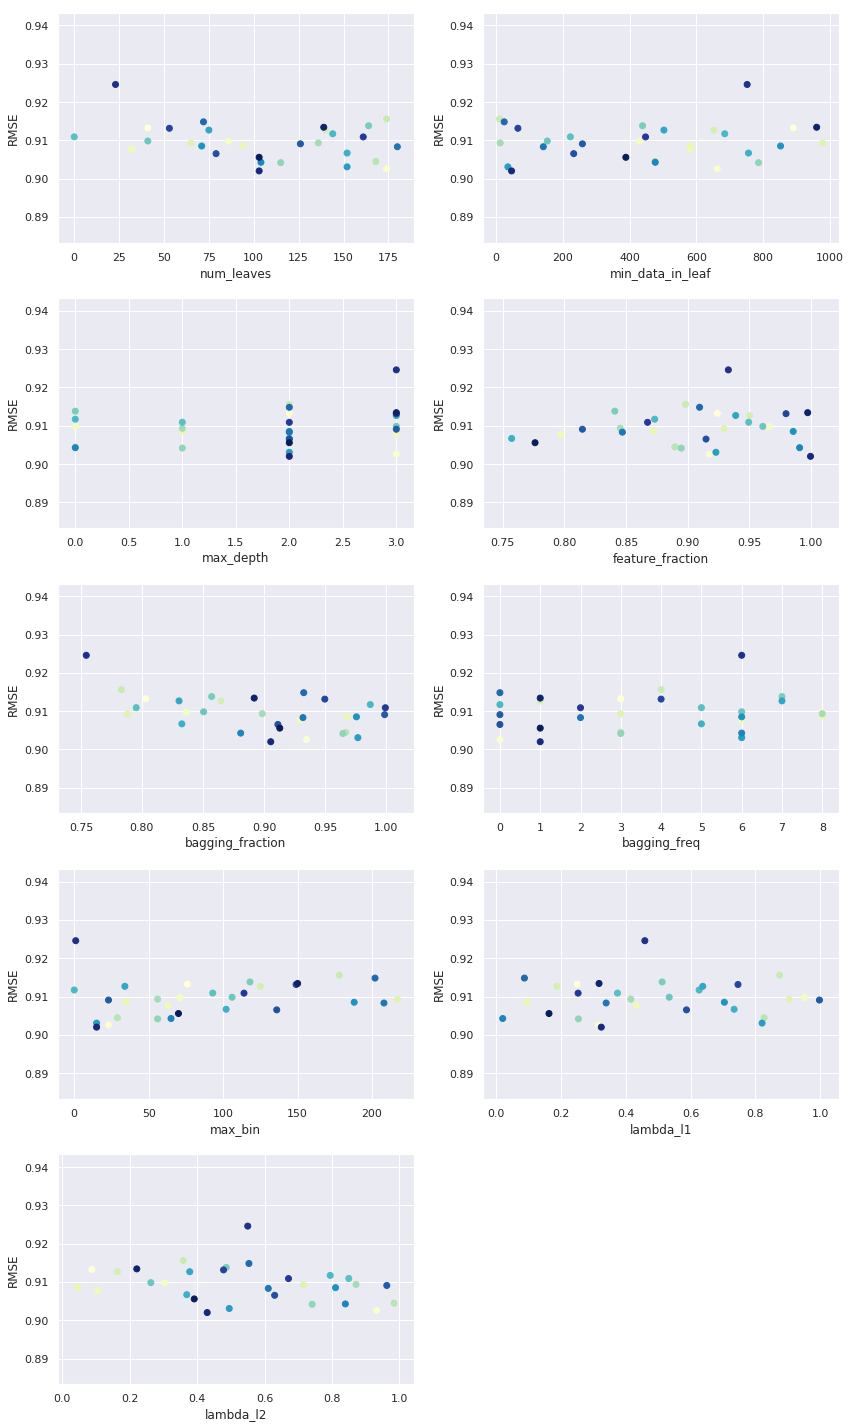

In [16]:
plot_trials(trials)

In [17]:
%%time
lgbm = setup_and_fit_model(new_params=tuned_params)

train_score 0.7744, valid_score 0.8882
CPU times: user 20min 30s, sys: 20.6 s, total: 20min 51s
Wall time: 5min 59s


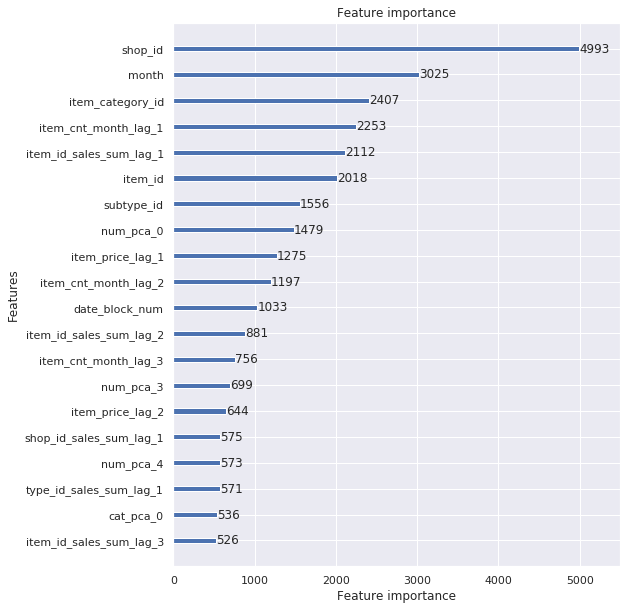

In [18]:
fig, ax = plt.subplots(figsize=(8, 10))

plotting.plot_importance(booster=lgbm, ax=ax, max_num_features=20);

In [19]:
tuned_preds = lgbm.predict(X_test)

print(tuned_preds.shape)

(1114452,)


### Bagging

In [20]:
def get_bagging_preds(new_params={}, trials=None):
    # Basic bagging algorithm
    # We can't use BaggingRegressor from sklearn here because of high RAM usage
    bagged_preds = np.zeros(X_test.shape[0])
    
    for i in range(BAGS):
        if trials is not None:
            # Take *BAGS* best configurations from hyperopt and average their predictions
            trial_idxs = np.argsort([t['result']['loss'] for t in trials.trials])
            # Rotate if BAGS bigger than the number of trials
            trial_idx = trial_idxs[i%len(trial_idxs)]
            trial_score = trials.trials[trial_idx]['result']['loss']
            print("{}/{}, {}th trial with score {:.4f}".format(i+1, BAGS, trial_idx, trial_score))
            sample = {param: arr[trial_idx] for param, arr in trials.vals.items()}
        else:
            # Average predictions based on random seed only
            random_state = random_state=SEED+i
            print(f"{i+1}/{BAGS}, seed {random_state}")
            sample = {'random_state': random_state}
            
        lgbm = setup_and_fit_model({**sample, **new_params})
        preds = lgbm.predict(X_test)
        bagged_preds += preds
        del lgbm
        # calling it at the end of a loop can help avoid fragmenting memory
        gc.collect()

    bagged_preds /= BAGS
    return bagged_preds

In [21]:
%%time
seed_bagging_preds = get_bagging_preds(new_params={'num_iterations': lgbm.get_params()['num_iterations']})

1/5, seed 42
train_score 0.8448, valid_score 0.9088
2/5, seed 43
train_score 0.8480, valid_score 0.9061
3/5, seed 44
train_score 0.8620, valid_score 0.9099
4/5, seed 45
train_score 0.8495, valid_score 0.9057
5/5, seed 46
train_score 0.8211, valid_score 0.9105
CPU times: user 28min 54s, sys: 1min 8s, total: 30min 2s
Wall time: 9min 50s


In [22]:
%%time
tuned_seed_bagging_preds = get_bagging_preds(new_params={'num_iterations': lgbm.get_params()['num_iterations'], **tuned_params})

1/5, seed 42
train_score 0.7744, valid_score 0.8882
2/5, seed 43
train_score 0.7896, valid_score 0.8948
3/5, seed 44
train_score 0.7816, valid_score 0.8931
4/5, seed 45
train_score 0.8161, valid_score 0.8983
5/5, seed 46
train_score 0.7881, valid_score 0.8896
CPU times: user 1h 24min 55s, sys: 1min 34s, total: 1h 26min 29s
Wall time: 25min 2s


In [23]:
%%time
tuned_trial_bagging_preds = get_bagging_preds(new_params={'num_iterations': lgbm.get_params()['num_iterations']}, trials=trials)

1/5, 27th trial with score 0.9020
train_score 0.9342, valid_score 0.9366
2/5, 1th trial with score 0.9026
train_score 0.9039, valid_score 0.9177
3/5, 17th trial with score 0.9031
train_score 0.9335, valid_score 0.9358
4/5, 10th trial with score 0.9042
train_score 0.9734, valid_score 0.9614
5/5, 19th trial with score 0.9043
train_score 0.8219, valid_score 0.9082
CPU times: user 1h 1min 36s, sys: 2min 1s, total: 1h 3min 38s
Wall time: 20min 8s


### Save predictions

In [24]:
def save_preds(preds, fname):
    preds = pd.Series(preds, index=test_idx)
    preds.to_csv(fname)
    print(preds.head())
    print(preds.describe()[['mean', 'std', 'min', 'max']])

In [25]:
save_preds(baseline_preds, 'baseline_preds.csv')

6278651    0.167961
6278652    0.327832
6278653    0.010301
6278654    0.076281
6278655    0.098524
dtype: float64
mean     0.269619
std      0.743964
min     -0.405938
max     20.763871
dtype: float64


In [26]:
save_preds(tuned_preds, 'tuned_preds.csv')

6278651    0.194287
6278652    0.163380
6278653    0.034108
6278654    0.104931
6278655    0.194931
dtype: float64
mean     0.261863
std      0.771941
min     -2.102124
max     22.289148
dtype: float64


In [27]:
save_preds(seed_bagging_preds, 'seed_bagging_preds.csv')

6278651    0.164273
6278652    0.337859
6278653    0.011980
6278654    0.086341
6278655    0.111647
dtype: float64
mean     0.269548
std      0.740011
min     -0.281278
max     20.399214
dtype: float64


In [28]:
save_preds(tuned_seed_bagging_preds, 'tuned_seed_bagging_preds.csv')

6278651    0.199247
6278652    0.205581
6278653    0.016604
6278654    0.088491
6278655    0.178667
dtype: float64
mean     0.263618
std      0.768954
min     -0.897436
max     22.642531
dtype: float64


In [29]:
save_preds(tuned_trial_bagging_preds, 'tuned_trial_bagging_preds.csv')

6278651    0.113632
6278652    0.294513
6278653   -0.025002
6278654    0.081814
6278655    0.156545
dtype: float64
mean     0.277028
std      0.702225
min     -0.218001
max     20.541128
dtype: float64
